In [18]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import pandas as pd
from astropy.table import Table, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.table import join
from scipy.optimize import minimize, curve_fit

import corner

In [19]:
try:
    import numdifftools as ndt
except ModuleNotFoundError as e:
    ! pip install --user numdifftools
    import numdifftools as ndt

In [20]:

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, vstack, hstack, join, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from datetime import datetime, timedelta

from scipy.ndimage import gaussian_filter1d

import os
from glob import glob

import psycopg2

from tqdm.notebook import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [21]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

In [22]:
def firstdigit(n):
    """Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    return np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)

def plot_radec(ra, dec):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    ra : pandas.Series or list
        List of candidate RA [deg].
    dec : pandas.Series or list
        List of candidate Dec [deg].
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    # Convert RA, Dec to radians.
    # Rotate the RA so that the plot goes 360->0 left to right.
    _ra = np.radians(120 - ra)
    _ra[_ra < -np.pi] += 2*np.pi
    _dec = np.radians(dec)

    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    ax.scatter(_ra, _dec, alpha=0.5, s=2)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['270', '240', '210', '180', '150', '120', '90', '60', '30', '0', '330'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    fig.tight_layout()
    
    return fig;

import requests

def get_cutout(targetid, ra, dec, width=300, height=300, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    os.makedirs('_cache', exist_ok=True)
    img_name = f'_cache/cutout_{targetid}_{width}_{height}.jpg'
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = f'https://www.legacysurvey.org/viewer/cutout.jpg?ra={ra}&dec={dec}&%22/pix=0.25&layer=ls-dr9&width={width}&height={height}&sga'
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.25/3600,
        'CRPIX1': width//2,
        'CRVAL1': ra,
        'NAXIS1': width,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.25/3600,
        'CRPIX2': height//2,
        'CRVAL2': dec,
        'NAXIS2': height
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [23]:
def clean_catalog(data):
    """Take a catalog matched to PV TF targets and apply quality cuts:
    * Keep only good redshifts (ZWARN==0, DELTACHI2>=25)
    * Ensure 1 main DESI TARGETID per SGA_ID
    * Ensure >1 distinct TARGETIDs per SGA_ID
    * Ensure targets are not all spatially coincident.
    
    Parameters
    ----------
    data : astropy.Table
        Table of TF redshift measurements and matched SGA_IDs.
    
    Returns
    -------
    data_tf: astropy.Table or None
        Data suitable for Tully-Fisher analysis, after basic cuts.
    """
    # All targets
    _ids_all, _counts_all = np.unique(tfuji['SGA_ID'], return_counts=True)

    # Identify targets with good redshifts.
    isgoodz = (data['ZWARN']==0) & (data['DELTACHI2']>=25)
    _ids_goodz, _counts_goodz = np.unique(data['SGA_ID'][isgoodz], return_counts=True)

    # Select SGA_IDs with at least 2 good associated redshifts.
    select = np.in1d(data['SGA_ID'], _ids_goodz[_counts_goodz > 1]) & isgoodz
    data = data[select].group_by('SGA_ID')

    # Storage for output.
    data_tf = None

    # Loop through the table and keep only SGA IDs with >= 2 unique TARGETIDs, where one is a MAIN survey target.
    sga_ids = np.unique(data['SGA_ID'])
    N = len(sga_ids)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_id in enumerate(sga_ids):
            progress_bar.update(1)
            tab = data[data['SGA_ID']==sga_id]

            # MAIN targets have a TARGETID that starts with 3. Ensure one is present.
            digits = firstdigit(tab['TARGETID'])
            if np.any(digits == 3):
                maintargetids = np.unique(tab['TARGETID'][digits==3].value)

                # Ensure there are at least two distinct TARGETIDs matched to this SGA_ID.
                ntargets = len(np.unique(tab['TARGETID'].value))
                if ntargets >= 2:

                    # Ensure the TARGETIDs correspond to distinct locations on the sky.
                    coords = SkyCoord(tab['TARGET_RA'], tab['TARGET_DEC'], frame='icrs', unit='degree')
                    is_distinct = np.any([c1.separation(c2).to_value('arcsec') > 1 for c1 in coords for c2 in coords])
                    if not is_distinct:
                        continue
                # Check that there two or more TARGETIDs.
                else:
                    continue
            # Check that there is a MAIN survey TARGETID associated with this SGA_ID.
            else:
                continue

            if data_tf is None:
                data_tf = tab
            else:
                data_tf = vstack([data_tf, tab])

    return data_tf

### Import fuji file

In [24]:
tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195
1092744369930241,194.325065734878,27.4857950068364,10378,sv3,0.34112572843082,7.87536530522298e-05,4,5.80425057094544,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3250657348779,27.48579500683636
1079550230396930,194.312068074608,27.4798777913963,10378,sv3,1.43883246626074,0.000118079246392633,4,1.41281921416521,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1092744369930242,194.312068074608,27.4798777913963,10378,sv3,0.141836800089955,6.14844128636576e-05,4,8.01571118086576,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1080141245579266,268.972484124775,62.5902888954075,10207,sv3,1.25885927887654,0.000161730072763419,4,4.86104696989059,fuji/healpix/sv3/bright/102/10207/redrock-sv3-bright-10207.fits,EXT,674212,268.972484124775,62.59028889540747


#### Multiple Counts

In [25]:
# All targets
_ids_all, _counts_all = np.unique(tfuji['SGA_ID'], return_counts=True)
_ids_all[_counts_all > 1]

123
848
896
1548
1583
1980
2497
3727
5288
5732
5958


In [26]:
# All targets with decent redshifts and observations suitable for the Tully-Fisher analysis
tfuji_tf = clean_catalog(tfuji)
_ids_goodz, _counts_goodz = np.unique(tfuji_tf['SGA_ID'], return_counts=True)
_ids_goodz[_counts_goodz > 1]

  0%|          | 0/1372 [00:00<?, ?it/s]

896
1548
1583
1980
2497
5732
5958
5964
8032
9519
9769


In [28]:
tfuji_goodz = np.in1d(tfuji_tf['SGA_ID'], _ids_goodz[_counts_goodz > 1])
tfuji_g = tfuji_tf[tfuji_goodz]
tfuji_g

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
39627817951955633,180.381827027663,1.29582683075782,27649,sv3,0.0224279674032048,2.44404472261522e-05,0,283.560888532142,fuji/healpix/sv3/bright/276/27649/redrock-sv3-bright-27649.fits,TFT,896,180.38182702766252,1.2958268307578154
1070144189104132,180.383498876859,1.29621479718706,27649,sv3,0.0222944544366663,2.83413346431536e-05,0,45.697032826487,fuji/healpix/sv3/bright/276/27649/redrock-sv3-bright-27649.fits,TFT,896,180.38349887685897,1.2962147971870641
39632941722111933,252.860799700982,33.0343044855604,9337,sv3,0.0621058276441731,7.86988716030476e-06,0,996.112674765289,fuji/healpix/sv3/bright/93/9337/redrock-sv3-bright-9337.fits,TFT,1548,252.86079970098154,33.03430448556036
1070869912748034,252.860062744453,33.03565124542,9337,sv3,0.0625669112434631,7.42303672319939e-06,0,437.830720379949,fuji/healpix/sv3/bright/93/9337/redrock-sv3-bright-9337.fits,TFT,1548,252.86006274445305,33.035651245420034
1071077795037187,236.813448650733,43.9957553864163,9923,sv3,0.0352887795291414,7.31620291911626e-06,0,550.152345106006,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.8134486507333,43.99575538641631
1084271934570499,236.813448650733,43.9957553864163,9923,sv3,0.0353008322684175,9.4825361822116e-06,0,335.291149647906,fuji/healpix/sv3/dark/99/9923/redrock-sv3-dark-9923.fits,TFT,1583,236.8134486507333,43.99575538641631
1071077795037186,236.810202992035,43.9950609278788,9923,sv3,0.0356212945166845,2.64003527378348e-05,0,36.7676933435723,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.81020299203462,43.99506092787884
39633149604397504,236.811825811888,43.9954081686317,9923,sv3,0.0354706088249934,6.27417750722545e-06,0,869.667408287525,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.81182581188813,43.995408168631656
1070114673786881,221.074180121106,0.0524636506683826,25945,sv3,0.517629896537837,8.60289560125964e-05,0,26.0517106279731,fuji/healpix/sv3/bright/259/25945/redrock-sv3-bright-25945.fits,TFT,1980,221.0741801211058,0.052463650668382586


### SGA

In [29]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:10]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [30]:
SGA_fuji = join(tfuji_g, SGA, keys_left='SGA_ID', keys_right='SGA_ID')
SGA_fuji.group_by('SGA_ID_1')

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
39627817951955633,180.381827027663,1.29582683075782,27649,sv3,0.0224279674032048,2.44404472261522e-05,0,283.560888532142,fuji/healpix/sv3/bright/276/27649/redrock-sv3-bright-27649.fits,TFT,896,180.38182702766252,1.2958268307578154,896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.00555

### Inclination cuts

In [31]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

q0 = 0.2

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

SGA_fuji['cosi'] = np.sqrt((SGA_fuji['BA']**2 - q0**2)/(1 - q0**2))
SGA_fuji['cosi'][np.isnan(SGA_fuji['BA'])] = 0 # Objects with b/a < 0.2

/tmp/ipykernel_34671/4117437931.py:14: RuntimeWarning: invalid value encountered in sqrt
  SGA_fuji['cosi'] = np.sqrt((SGA_fuji['BA']**2 - q0**2)/(1 - q0**2))


In [36]:
for j in range (0,20):
    for i in range(0, len(SGA_fuji)):
        cosi = (SGA_fuji['cosi'][i])
        
    # Inclination cut
        if cosi < cosi_max:
            continue
        
    #print(i, cosi)
        SGA_fuji.remove_row(i)

In [37]:
_ids_all, _counts_all = np.unique(SGA_fuji['SGA_ID_1'], return_counts=True)
_ids_all[_counts_all > 1]

1548
1583
5732
8032
9519
9769
10133
10325
11977
11998
13851


### Morphology Cut

In [44]:
for j in range(0,20): 
    for i in range(0, len(SGA_fuji)):
        morphtype = str(SGA_fuji['MORPHTYPE'][i])
    
        # Cut any objects that do not start with 'S' (non-spirals)
        if morphtype.startswith('S'):
            continue
        
    #print(i, morphtype)
        SGA_fuji.remove_row(i)

In [45]:
_ids_all, _counts_all = np.unique(SGA_fuji['SGA_ID_1'], return_counts=True)
_ids_all[_counts_all > 1]

1548
1583
5732
8032
10325
11977
11998
15005
16383
19235
19682


## Cluster Membership

In [46]:
hdu = fits.open('DESI_SGA/TF/Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

#table3[:100]

In [47]:
hdu = fits.open('DESI_SGA/TF/Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

#table2[:10]

### Coma

In [48]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [49]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

In [50]:
idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

In [51]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [52]:
tf_coords = SkyCoord(SGA_fuji['TARGET_RA'], SGA_fuji['TARGET_DEC'], unit='deg')

sep = Coma_coords.separation(tf_coords)

In [53]:
fuji_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (SGA_fuji['Z']*c > V_Coma - 3*sigma_Coma) & (SGA_fuji['Z']*c < V_Coma + 3*sigma_Coma)

fuji_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (sep < 3*R2t_Coma_angle) & (SGA_fuji['Z']*c > V_Coma - 2*sigma_Coma) & (SGA_fuji['Z']*c < V_Coma + 2*sigma_Coma)

fuji_in_Coma = fuji_in_Coma1 | fuji_in_Coma2

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
fuji_ID_in_Coma = np.unique(SGA_fuji['SGA_ID_1'][fuji_in_Coma])

idx_fuji_in_coma = np.in1d(SGA_fuji['SGA_ID_1'], fuji_ID_in_Coma)

inComa_fuji_table = SGA_fuji[idx_fuji_in_coma]
################################################################################

inComa_fuji_table

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,cosi
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
1070791412154372,195.515245590946,29.2579670504378,10404,sv3,0.0252901358683873,6.06787928236001e-05,0,205.157615634467,fuji/healpix/sv3/bright/104/10404/redrock-sv3-bright-10404.fits,TFT,8032,195.5152455909458,29.257967050437784,8032,SGA-2020 8032,PGC044973,44973,195.517491,29.2534624,S0-a,156.32,0.97949,0.2421029,0.024316488,23.724482,15.141,False,LEDA-20181114,2184,PGC044973,1,True,195.517491,29.2534624,0.97949,1955p292,195.5175248072576,29.25343316744243,1.8002833,SB26,156.31898,0.22679013,195.51743607523957,29.253486909767386,32.501602,8.985235,8.994681,9.083619,23.624466,25.627426,28.065012,31.291449,35.26118,39.489708,44.38289,49.540756,54.0085,14.082667,13.18872,12.5554495,14.06491,13.172938,12.538263,14.050751,13.159123,12.524292,14.037637,13.146002,12.511435,14.028892,13.136262,12.501996,14.019759,13.1276045,12.493453,14.010117,13.12019,12.48436,14.004535,13.115231,12.47924,14.003234,13.112325,12.477641,0.24884425,0.17718974,0.26937655,0.27095935,0.2903059,0.34909678,0.34555468,0.35385203,0.33667165,0.028146377,0.029029278,0.029033912,0.027740175,0.028643928,0.028623551,0.027410619,0.028309358,0.028285725,0.027101276,0.027988376,0.027971063,0.02688788,0.027755244,0.027735293,0.026669523,0.027540853,0.02752354,0.026443765,0.027348971,0.027

Text(0, 0.5, 'Count')

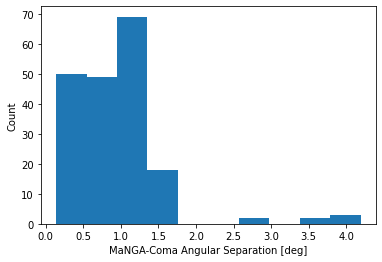

In [54]:
plt.hist(sep[fuji_in_Coma].to_value('degree'))
plt.xlabel('MaNGA-Coma Angular Separation [deg]')
plt.ylabel('Count')

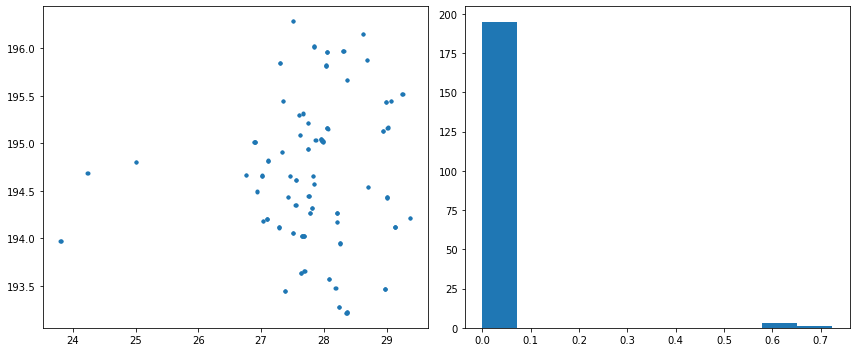

In [55]:
fig, axes = plt.subplots(1,2, figsize=(12,5), tight_layout=True)
ax = axes[0]
ax.plot(inComa_fuji_table['TARGET_DEC'], inComa_fuji_table['TARGET_RA'], '.')
ax = axes[1]
ax.hist(inComa_fuji_table['Z']);

#### Galaxies with more than one count

In [56]:
ids, counts = np.unique(inComa_fuji_table['SGA_ID_1'], return_counts=True)
ids[counts > 1]

8032
25532
30149
98934
100987
122260
191275
191496
196592
202666
291879


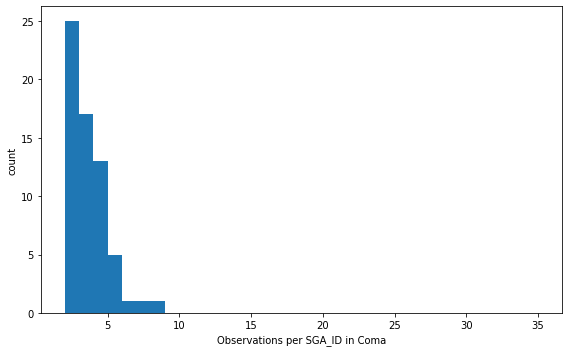

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

ax.hist(counts[counts > 1], bins=np.linspace(2,35,34))

ax.set(xlabel='Observations per SGA_ID in Coma', 
       ylabel='count');

In [58]:
# Keep only those with more than one observation
high_count_sga = np.in1d(inComa_fuji_table['SGA_ID_1'], ids[counts > 1])
tf_coma_multiple = inComa_fuji_table[high_count_sga]
tf_coma_multiple

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,cosi
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
1070791412154372,195.515245590946,29.2579670504378,10404,sv3,0.0252901358683873,6.06787928236001e-05,0,205.157615634467,fuji/healpix/sv3/bright/104/10404/redrock-sv3-bright-10404.fits,TFT,8032,195.5152455909458,29.257967050437784,8032,SGA-2020 8032,PGC044973,44973,195.517491,29.2534624,S0-a,156.32,0.97949,0.2421029,0.024316488,23.724482,15.141,False,LEDA-20181114,2184,PGC044973,1,True,195.517491,29.2534624,0.97949,1955p292,195.5175248072576,29.25343316744243,1.8002833,SB26,156.31898,0.22679013,195.51743607523957,29.253486909767386,32.501602,8.985235,8.994681,9.083619,23.624466,25.627426,28.065012,31.291449,35.26118,39.489708,44.38289,49.540756,54.0085,14.082667,13.18872,12.5554495,14.06491,13.172938,12.538263,14.050751,13.159123,12.524292,14.037637,13.146002,12.511435,14.028892,13.136262,12.501996,14.019759,13.1276045,12.493453,14.010117,13.12019,12.48436,14.004535,13.115231,12.47924,14.003234,13.112325,12.477641,0.24884425,0.17718974,0.26937655,0.27095935,0.2903059,0.34909678,0.34555468,0.35385203,0.33667165,0.028146377,0.029029278,0.029033912,0.027740175,0.028643928,0.028623551,0.027410619,0.028309358,0.028285725,0.027101276,0.027988376,0.027971063,0.02688788,0.027755244,0.027735293,0.026669523,0.027540853,0.02752354,0.026443765,0.027348971,0.027

In [59]:
sga_ids_vel_cuts = []

rmag = []
drmag = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(inComa_fuji_table['SGA_ID_1'])):
    # if sga_id == 474614:
    #     print('skipped')
    #     continue
    galaxy_list = inComa_fuji_table[inComa_fuji_table['SGA_ID_1'] == sga_id]
    # print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    # print(good_vel[0], sga_id)
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.3) & (sep_r26 < 0.4)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            rmag.append(float(sga_galaxy['R_MAG_SB26']))
            drmag.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax.append(v033)
            dvmax.append(dv033)
            sga_ids_vel_cuts.append(sga_id)
    # break
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

55


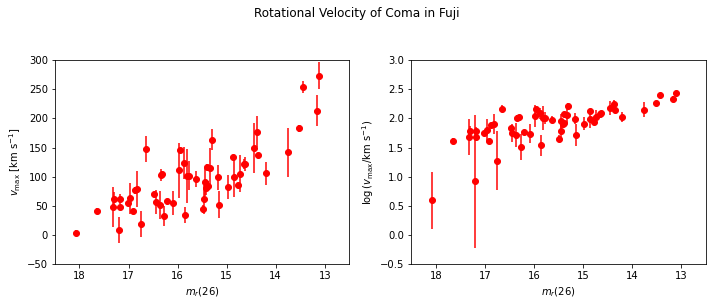

In [60]:
rmag = np.asarray(rmag)
drmag = np.asarray(drmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], xerr=drmag[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational Velocity of Coma in Fuji', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

In [61]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

inComa_fuji_table['cosi'] = np.sqrt((inComa_fuji_table['BA']**2 - q0**2)/(1 - q0**2))
inComa_fuji_table['cosi'][np.isnan(inComa_fuji_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

# for sga_id in np.unique(inComa_sga_table['SGA_ID']):
for sga_id in sga_ids_vel_cuts:
    galaxy_list = inComa_fuji_table[inComa_fuji_table['SGA_ID_1'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.35) & (sep_r26 < 0.45)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)
            z.append(zc)
            rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
            drmag_clean.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
            sga_ids_clean.append(sga_id)
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

0


### Using fit from TF_Coma.ipynb

In [62]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def l2norm(pars, x, y, dy):
    '''
    Linear fit that uses the l2-norm
    '''
    a, b = pars
    return np.sum((y - a - b*x)**2/dy**2)

def fit_tfr(r, logv, dlogv):
    fmin = 1e99
    a, b = 6, -0.25
    hess_inv = np.ones((2,2))
    
    succ_res = None
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(1000):
        _a, _b = np.random.uniform(0,10), np.random.uniform(-1,0)
        
        res = minimize(l1norm_noerror, 
                       [_a, _b], 
                       args=(r, logv),# dlogv),
                       method='L-BFGS-B', 
                       bounds=[[0,10], [-1,1]])
        
        if res.fun < fmin and res.success:
            print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
    
    if succ_res is None:
        print('No successful fits')
    else:
        print(succ_res)
    
    return a, b, hess_inv

Original
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 8.094061448406718, 'jac': array([ 0.98217239, 14.50355907]), 'nfev': 348, 'njev': 116, 'nit': 27, 'status': 0, 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 4.37333403, -0.15607034]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
4.373334025326909 -0.15607034254604257


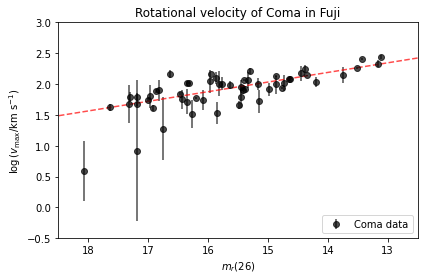

In [63]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
print('Original')

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.7,
            label='Coma data')

a, b, _ = fit_tfr(rmag[isrmeas], log10vmax[isrmeas], dlog10vmax[isrmeas])
print(a, b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.7)
################################################################################


################################################################################
# Cleaned data
#-------------------------------------------------------------------------------
'''
print('\nCleaned')

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b, _ = fit_tfr(rmag_clean[isrmeas_clean], 
                  log10vmax_clean[isrmeas_clean], 
                  dlog10vmax_clean[isrmeas_clean])
print(a, b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
'''
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity of Coma in Fuji')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

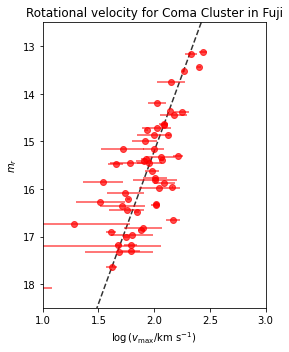

In [65]:
fig, ax = plt.subplots(1,1, figsize=(4,5), tight_layout=True)

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean

r = np.arange(12.5,18.6,0.1)
v = a + b*r

################################################################################
# Compute and plot the uncertainty range around the best fit
#-------------------------------------------------------------------------------
'''
hessian = ndt.Hessian(l1norm)
hess = hessian((a,b), 
               rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])

N_samples = 1000

random_samples = np.random.multivariate_normal(mean=(a,b), 
                                               cov=np.linalg.inv(np.abs(hess)), #hess_inv.matmat(np.eye(2)), 
                                               size=N_samples)

y_samples = np.zeros([1000, len(r)])
for i in range(len(r)):
    y_samples[:,i] = random_samples[:,0] + random_samples[:,1]*r[i]

std_dev = np.std(y_samples, axis=0)

ax.fill_betweenx(r, v-std_dev, v+std_dev, facecolor='lightgray')
'''
################################################################################

ax.plot(v, r, 'k--', alpha=0.8)

ax.errorbar(log10vmax[isrmeas], 
            rmag[isrmeas], 
            xerr=dlog10vmax[isrmeas], 
            fmt='ro', 
            alpha=0.7)

ax.set(ylabel='$m_r$',
       ylim=(18.5, 12.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(1,3),
       title='Rotational velocity for Coma Cluster in Fuji');

#plt.savefig('../Figures/PV_TFR_Coma_fitWOerrors_09262021.eps', format='eps', dpi=120);

### Hyperfit

In [78]:
# Create a 2x2xN matrix.
ndata = len(dlog10vmax[isrmeas])
cov = np.empty((2, 2, ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i, (dlogv, dm) in enumerate(zip(dlog10vmax[isrmeas], drmag[isrmeas])):
    cov[:,:,i] = np.array([[dlogv**2, 0.], [0., dm**2]])
                              
# cov[:,:,0]

In [67]:
from hyperfit.linfit import LinFit
from chainconsumer import ChainConsumer

In [68]:
logv = log10vmax[isrmeas]
mr = rmag[isrmeas]
logv.shape, mr.shape

((55,), (55,))

In [69]:
hf = LinFit([logv, mr], cov)

In [70]:
# Run an MCMC
bounds = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

# # Make the plot
# data.plot(linfit=hf)

     fun: array([-73.62108473])
     jac: array([0.00299991, 0.00157883, 0.0001279 ])
 message: 'Optimization terminated successfully.'
    nfev: 4700
     nit: 103
 success: True
       x: array([4.17719905, 0.61541555, 0.11307141])


100%|██████████| 1000/1000 [00:00<00:00, 1206.93it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.33840563 42.90006815 35.35437723] / 2145.0034075954563


100%|██████████| 1000/1000 [00:00<00:00, 1108.69it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [58.71629096 58.5798644  35.36559843] / 2935.8145479400596


100%|██████████| 1000/1000 [00:00<00:00, 1178.05it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.19424233 51.15395915 29.51184353] / 2559.712116254102


100%|██████████| 1000/1000 [00:00<00:00, 1199.10it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.79061043 52.32877151 38.68745581] / 2639.530521340198


100%|██████████| 1000/1000 [00:00<00:00, 1112.63it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [55.53254519 55.17971108 46.36680881] / 2776.627259710466


100%|██████████| 1000/1000 [00:00<00:00, 1148.61it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.59444756 58.10186445 47.04675772] / 2905.0932227194858


100%|██████████| 1000/1000 [00:00<00:00, 1124.59it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [63.18265841 63.01015666 50.69355165] / 3159.132920685991


100%|██████████| 1000/1000 [00:00<00:00, 1173.80it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [61.48574064 61.90922534 51.57564131] / 3095.4612671374557
[-6.82925942 29.04175647  0.83344237] [0.85026668 1.68863944 0.1568406 ]


### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and m_r, and the color given by the best-fit scatter parameter sigma_i.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [71]:
a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -6.83 +/- 0.85
 29.04 +/- 1.69
  0.83 +/- 0.16


#### Corner Plot

In [72]:
import corner

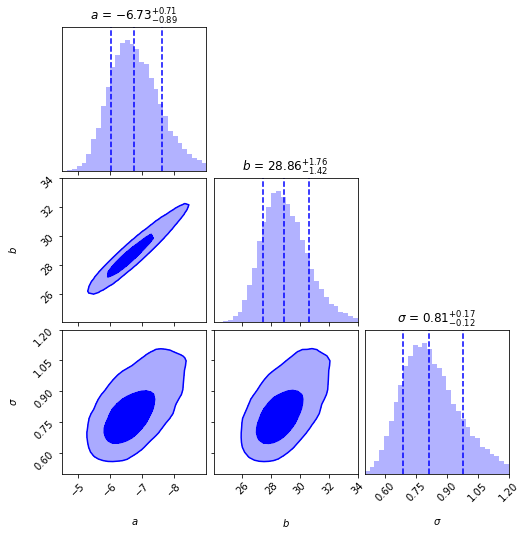

In [73]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
             range=[[-4.5, -9], [24, 34], [.5, 1.2]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 12})

In [74]:
import cmocean

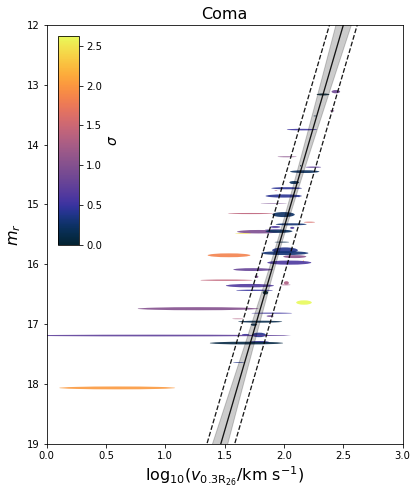

In [75]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [log10vmax[isrmeas], rmag[isrmeas]]
x_err = dlog10vmax[isrmeas]
y_err = drmag[isrmeas]
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2.0 * y_err[i],
        height=2.0 * x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
fig = plt.figure(figsize=(6,7))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.set_xlabel(r"$\log_{10}{(v_\mathrm{0.3R_{26}} / \mathrm{km~s^{-1}})}$", fontsize=16)
ax.set_ylabel(r"$m_r$", fontsize=16)
ax.set_title(r"Coma", fontsize = 16)
ax.set_xlim(0, 3)
ax.set_ylim(19, 12)

# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmocean.cm.thermal),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)